# SageMaker Endpoint에 사전 훈련된 모델을 호스팅 후 Object Detection 수행하기 (MXNet-GluonCV)
---

Amazon SageMaker에서 추론(inference)을 수행하려면 반드시 SageMaker에서 먼저 훈련을 수행해야 하나요? 그렇지 않습니다.<br>
만약 여러분이 SageMaker에서 추론만 수행하고 싶다면, 여러분의 온프레미스(on-premise)에서 훈련한 모델이나 공개 모델 저장소(model zoo)에 저장되어 있는 사전 훈련된(pre-trained) 모델들을 도커(Docker) 이미지 빌드 없이 그대로 SageMaker Endpoint에 배포할 수 있습니다. 
여러분이 수행할 작업은 오로지 추론용 엔트리포인트(entrypoint)만 작성하는 것입니다.

이 노트북에서는 MXNet의 GluonCV API를 사용하여 사전 훈련된 `yolo3_darknet53_coco` 모델을 SageMaker 엔드포인트에 배포 후, Object Detection을 수행합니다. GluonCV는 컴퓨터 비전 분야의 최신(SOTA; State of the art) 딥러닝 사전 훈련된 모델들을 model zoo로 제공할 뿐 아니라, 컴퓨터 비전에서 많이 쓰이는 기능들을 명확하고 간결한 API로 제공합니다. 


## Pre-requisites

- 기본 용법: [GluonCV](https://gluon-cv.mxnet.io/tutorials/index.html), [MXNet](https://mxnet.apache.org/)
- AWS 서비스: [AWS S3](https://docs.aws.amazon.com/s3/index.html), [Amazon SageMaker](https://aws.amazon.com/sagemaker/)

In [1]:
%load_ext autoreload
%autoreload 2

<br>

# 1. Inference script
---

아래 코드 셀은 `src` 디렉토리에 SageMaker 추론 스크립트를 저장합니다.<br>

이 스크립트는 SageMaker 상에서 MXNet에 최적화된 추론 서버인 MMS(Multi Model Server)나 PyTorch에 최적화된 추론 서버인 torchserve를 쉽고 편하게 배포할 수 있는 high-level 툴킷인 SageMaker inference toolkit의 인터페이스를 사용하고 있으며, 여러분께서는 인터페이스에 정의된 핸들러(handler) 함수들만 구현하시면 됩니다. MXNet 및 PyTorch용 엔트리포인트(entrypoint) 인터페이스는 아래 두 가지 옵션 중 하나를 선택하면 되며, 본 예제에서는 Option 1.의 사용 예시를 보여줍니다.


### Option 1.
- `model_fn(model_dir)`: 딥러닝 네트워크 아키텍처를 정의하고 S3의 model_dir에 저장된 모델 아티팩트를 로드합니다.
- `input_fn(request_body, content_type)`: 입력 데이터를 전처리합니다. (예: request_body로 전송된 bytearray 배열을 PIL.Image로 변환 수 cropping, resizing, normalization등의 전처리 수행). content_type은 입력 데이터 종류에 따라 다양하게 처리 가능합니다. (예: application/x-npy, application/json, application/csv 등)
- `predict_fn(input_object, model)`: input_fn을 통해 들어온 데이터에 대해 추론을 수행합니다. 
- `output_fn(prediction, accept_type)`: predict_fn에서 받은 추론 결과를 추가 변환을 거쳐 프론트 엔드로 전송합니다. 

### Option 2. 
- `model_fn(model_dir)`: 딥러닝 네트워크 아키텍처를 정의하고 S3의 model_dir에 저장된 모델 아티팩트를 로드합니다.
- `transform_fn(model, request_body, content_type, accept_type)`: input_fn(), predict_fn(), output_fn()을 transform_fn()으로 통합할 수 있습니다.

In [2]:
%%writefile src/inference_mxnet.py

import os
import time
import sys
import json
import subprocess
from base64 import b64decode

# Install/Update GluonCV:
subprocess.call([sys.executable, '-m', 'pip', 'install', 'gluoncv'])

import mxnet as mx
import gluoncv as gcv
ctx = mx.cpu()

def model_fn(model_dir=None):
    '''
    Loads the model into memory from storage and return the model.
    '''    
    net = gcv.model_zoo.get_model(
        'yolo3_darknet53_coco',
        pretrained=True,
        ctx=ctx,
    )
    net.hybridize(static_alloc=True, static_shape=True)
    #net.load_parameters(os.path.join(model_dir, 'model.params'), ctx=ctx)
    return net

def input_fn(request_body, content_type):
    '''
    Deserialize the request body
    '''    
    if content_type == 'application/json':
        D = json.loads(request_body)

        short = D.get('short')
        image = b64decode(D['image'])
        x, _ = gcv.data.transforms.presets.yolo.transform_test(
            mx.image.imdecode(image), short=short
        )
        return x
    else:
        raise RuntimeError(f'Not support content-type: {content_type}')


def predict_fn(input_object, model):
    '''
    Predicts on the deserialized object with the model from model_fn().
    '''
    x = input_object
    
    t0 = time.time()
    cid, score, bbox = model(x.as_in_context(ctx))
    t1 = time.time() - t0
    print("--- Elapsed time: %s secs ---" % t1)

    return x.shape, cid[0], score[0], bbox[0]


def output_fn(prediction, content_type):
    '''
    Serializes predictions from predict_fn() to JSON format.
    '''    
    shape, cid, score, bbox = prediction
    if content_type == 'application/json':
        return json.dumps({
            'shape': shape,
            'cid': cid.asnumpy().tolist(),
            'score': score.asnumpy().tolist(),
            'bbox': bbox.asnumpy().tolist()
        })

Overwriting src/inference_mxnet.py


Object Detection에 필요한 유틸리티 함수들을 정의합니다.

In [3]:
%%writefile src/utils.py

def get_label_map(label_file):
    label_map = {}
    labels = open(label_file, 'r')
    
    for line in labels:
        line = line.rstrip("\n")
        ids = line.split(',')
        label_map[int(ids[0])] = ids[2] 
        
    return label_map


def delete_endpoint(client, endpoint_name):
    response = client.describe_endpoint_config(EndpointConfigName=endpoint_name)
    model_name = response['ProductionVariants'][0]['ModelName']

    client.delete_model(ModelName=model_name)    
    client.delete_endpoint(EndpointName=endpoint_name)
    client.delete_endpoint_config(EndpointConfigName=endpoint_name)    
    
    print(f'--- Deleted model: {model_name}')
    print(f'--- Deleted endpoint: {endpoint_name}')
    print(f'--- Deleted endpoint_config: {endpoint_name}')    
    
    
def plot_bbox(img_resized, bboxes, scores, cids, class_info, framework='pytorch', threshold=0.5):

    import numpy as np
    import random
    import matplotlib.patches as patches
    import matplotlib.pyplot as plt
    
    if framework=='mxnet':
        img_np = img_resized.asnumpy()
        scores = scores.asnumpy()
        bboxes = bboxes.asnumpy()
        cids = cids.asnumpy()
    else:
        img_np = img_resized
        scores = np.array(scores)
        bboxes = np.array(bboxes)
        cids = np.array(cids)    

    # Get only results that are above the threshold. Default threshold is 0.5. 
    scores = scores[scores > threshold]
    num_detections = len(scores)
    bboxes = bboxes[:num_detections, :]
    cids = cids[:num_detections].astype('int').squeeze()

    # Get bounding-box colors
    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i) for i in np.linspace(0, 1, 20)]
    random.seed(42)
    random.shuffle(colors)
    
    plt.figure()
    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.imshow(img_np)

    if cids is not None:
        # Get unique class labels 
        unique_labels = set(list(cids.astype('int').squeeze()))
        unique_labels = np.array(list(unique_labels))
        n_cls_preds = len(unique_labels)
        bbox_colors = colors[:n_cls_preds]

        for b, cls_pred, cls_conf in zip(bboxes, cids, scores):
            x1, y1, x2, y2 = b[0], b[1], b[2], b[3]
            predicted_class = class_info[int(cls_pred)]
            label = '{} {:.2f}'.format(predicted_class, cls_conf)
            
            # Get box height and width
            box_h = y2 - y1
            box_w = x2 - x1

            # Add a box with the color for this class
            color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
            bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=3, edgecolor=color, facecolor='none')
            ax.add_patch(bbox)

            plt.text(x1, y1, s=label, color='white', verticalalignment='top',
                    bbox={'color': color, 'pad': 0})

Overwriting src/utils.py


<br>

# 2. SageMaker Hosted Endpoint Inference
---

이제 실제 운영 환경에 엔드포인트 배포를 수행해 보겠습니다.


> 본 핸즈온에서는 로컬 디버깅 및 로컬 모드 배포 없이 곧바로 호스팅 엔드포인트로 배포하지만, 충분한 검증 및 테스트 없이 훈련된 모델을 곧바로 실제 운영 환경에 배포하기에는 많은 위험 요소들이 있습니다. 따라서, 로컬 모드를 사용하여 실제 운영 환경에 배포하기 위한 추론 인스턴스를 시작하기 전에 노트북 인스턴스의 로컬 환경에서 모델을 배포하는 것을 권장합니다. 로컬 디버깅 및 로컬 모드 엔드포인트에 대한 예제는 [PyTorch 예제](pytorch-serving-endpoint.ipynb) 를 참조해 주세요.

In [10]:
import os
import time
import sagemaker
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import JSONSerializer
from sagemaker.mxnet import MXNetModel
role = sagemaker.get_execution_role()

## Model Packaging

Fine-tuning 없이 곧바로 사전 훈련된 모델을 사용할 것이므로 `model.tar.gz`는 0바이트의 빈 파일로 구성합니다.
만약 온프레미스에서 fine-tuning을 수행한 모델을 사용하고 싶다면, 모델 파라메터들을 `model.tar.gz`로 압축하세요.

In [5]:
f = open("model.params", 'w')
f.close()
!tar -czf model.tar.gz model.params

## Model Preparing

`model.tar.gz`를 S3로 복사합니다. SageMaker 상에서 훈련을 수행했다면 이미 S3에 저장되어 있지만, 다른 인프라에서 훈련을 수행한 경우에는 직접 S3로 복사해 주셔야 합니다. 

#### [주의] 아래 코드 셀을 그대로 실행하지 마시고 bucket 이름을 반드시 수정해 주세요.
```python
bucket = '[YOUR-S3-BUCKET]' # as-is
bucket = 'sagemaker-hol-daekeun' # to-be
```

In [6]:
#bucket = '[YOUR-S3-BUCKET]' # bucket 이름을 반드시 수정해 주세요.
#bucket = 'sagemaker-hol-daekeun'
bucket = sagemaker.Session().default_bucket() # SageMaker에서 자동으로 생성되는 bucket

In [7]:
%%bash -s "$role" "$bucket"
ROLE=$1
BUCKET=$2

aws s3 cp model.tar.gz s3://$BUCKET/model.tar.gz

upload: ./model.tar.gz to s3://sagemaker-us-east-1-143656149352/model.tar.gz


In [8]:
endpoint_name = f'endpoint-mxnet-{int(time.time())}'
model_path = f's3://{bucket}/model.tar.gz'
#model_path = f'file://{os.getcwd()}/model.tar.gz' # for local mode

## Model Deployment 

SageMaker SDK로 모델 배포를 수행하는 방법은 매우 간단합니다. PyTorch으로 배포 시에는 엔트리포인트 코드를 PyTorch용으로 변경 후, `MXNetModel` 대신 `PyTorchModel` 클래스로 인스턴스를 생성하면 됩니다.

#### CPU/GPU

본 노트북에서는 범용 컴퓨팅 CPU 인스턴스로 추론을 수행합니다. 왜일까요?<br>
머신러닝 워크로드의 전체 비용을 고려할 때 추론이 전체 비용의 90%를 차지하는 경우가 많습니다. **<font color='red'>즉, 추론 시 GPU를 그대로 사용하게 되면 매우 많은 비용이 발생하게 됩니다.</font>**<br>
따라서, 대량의 데이터를 배치 변환(batch transform)해야 하거나 응답 속도가 매우 빨라야 하는(예: 10ms) 어플리케이션이 아닌 이상 CPU 인스턴스로 먼저 추론을 수행하세요.

#### Elastic Inference
응답 속도가 매우 빨라야 하는 어플리케이션의 경우 GPU 인스턴스의 사용을 고려하게 될 수 있습니다.
하지만, GPU 인스턴스 유형이 실시간 추론에 사용되는 경우 일반적으로 훈련과 달리 실시간 훈련에는 대량의 데이터를 모델에 지속적으로 입력하지 않으므로 일반적으로 완전히 활용되지 않습니다.<br>
Elastic Inference는 추론에 적합한 GPU 가속을 제공하므로, 범용 컴퓨팅 CPU 인스턴스와 Elastic Inference를 같이 활용하면 GPU 인스턴스를 사용하는 것보다 훨씬 저렴한 비용으로 Endpoint를 호스팅할 수 있습니다. 
자세한 내용은 아래 링크를 참조해 주세요.<br>
https://docs.aws.amazon.com/ko_kr/sagemaker/latest/dg/ei.html

SageMaker가 관리하는 배포 클러스터를 프로비저닝하고 추론 컨테이너를 배포하기 때문에, 추론 서비스를 시작하는 데에는 약 5~10분 정도 소요됩니다.

In [11]:
%%time
model = MXNetModel(model_data=model_path,
                   role=role,
                   entry_point='inference_mxnet.py', 
                   source_dir='src',
                   framework_version='1.6.0',
                   py_version='py3')

predictor = model.deploy(
    initial_instance_count=1,
    instance_type='ml.c5.large',
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer()
)

-------------!CPU times: user 511 ms, sys: 34.4 ms, total: 545 ms
Wall time: 6min 33s


<br>


# 2. Real-time Inference
----

Endpoint 생성이 완료되었으면, 테스트 영상에 대한 Object Detection을 수행해 보겠습니다.


In [12]:
!pip install -q gluoncv

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.


## Label Map 딕셔너리 변환
Class 레이블에 대응하는 클래스명을 가져옵니다.

In [13]:
from src.utils import get_label_map, delete_endpoint, plot_bbox
label_map = get_label_map('files/coco_labels.txt')
label_list = list(label_map.values())
print(label_map)

{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77: 'cell phone', 78: 'micro

## Get Inference Result

테스트 이미지로 COCO dataset(http://cocodataset.org/#download) 의 2017 Val images를 6장 준비했습니다. 핸즈온을 잘 진행하셨다면, 주어진 6장의 영상 파일들 외에 여러분의 영상 파일들을 업로드하여 자유롭게 테스트해 보세요.<br>

참고로, Object Detection 출력 결과인 bounding box의 기본 임계치(threshold)는 0.5입니다.

In [14]:
def get_inference(img_path):
    with open(img_path, 'rb') as fp:
        bimage = fp.read()
        
    input_json = {
        'short': 416, # YOLO's recommended image size
        'image': b64encode(bimage).decode('utf-8') 
    }
    
    outputs = predictor.predict(input_json)
    
    shape = outputs['shape']
    cids = mx.nd.array(outputs['cid'])
    scores = mx.nd.array(outputs['score'])
    bboxes = mx.nd.array(outputs['bbox'])    
    img_resized = mx.image.imresize(mx.image.imdecode(bimage), shape[3], shape[2])
    #request_body = json.dumps(input_json) # for testing on local    
    
    return img_resized, cids, scores, bboxes

In [15]:
import os
from base64 import b64encode, b64decode
import json
import mxnet as mx
from gluoncv import utils
from io import BytesIO
from PIL import Image

path = "./images/test"
img_list = os.listdir(path)
img_path_list = [os.path.join(path, img) for img in img_list]

### GluonCV API로 Bounding box plotting
GluonCV의 `plot_bbox` 메소드로 Object Detection 결과를 쉽게 plotting할 수 있습니다. 

In [16]:
%matplotlib inline

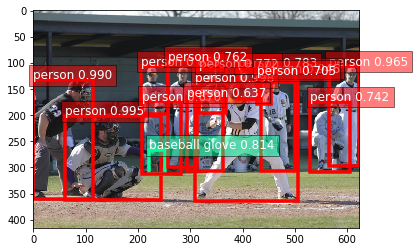

In [17]:
test_idx = 1
img_path = img_path_list[test_idx]
img_resized, cids, scores, bboxes = get_inference(img_path)
ax = utils.viz.plot_bbox(img_resized, bboxes, scores, cids, class_names=label_list)

### 직접 구현한 함수로 Bounding Box 그리기
물론, high-level API에 의존하지 않고 직접 bounding box를 그릴 수 있습니다. 본 주피터 노트북에서 정의한 `utils.py` 를 참조해 주세요. 

<Figure size 432x288 with 0 Axes>

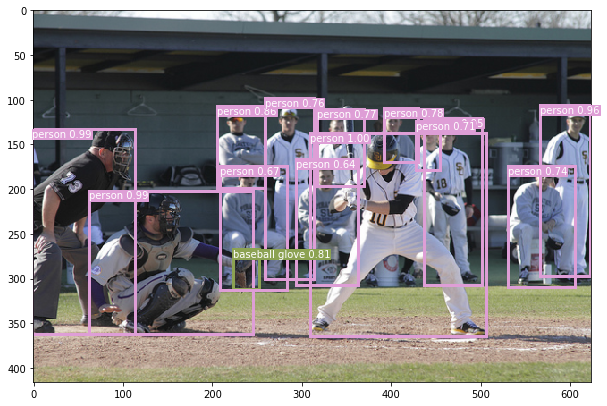

In [18]:
plot_bbox(img_resized, bboxes, scores, cids, class_info=label_list, framework='mxnet')

## Endpoint Clean up

SageMaker Endpoint로 인한 과금을 막기 위해, 본 핸즈온이 끝나면 반드시 Endpoint를 삭제해 주시기 바랍니다.

In [19]:
predictor.delete_endpoint()